In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
!pip install yfinance

In [26]:
!pip install torch-summary

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [28]:
ticker = yf.Ticker("TATAMOTORS.NS")

# Define the start and end dates
start_date = "2016-06-14"
end_date = "2024-10-01"
# Get historical data for the specified date range
df = ticker.history(start=start_date, end = end_date)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-24 00:00:00+05:30,974.000000,985.000000,972.599976,977.299988,12755422,0.0,0.0
2024-09-25 00:00:00+05:30,982.400024,982.500000,959.250000,963.599976,12959075,0.0,0.0
2024-09-26 00:00:00+05:30,970.799988,994.950012,965.599976,993.150024,21640021,0.0,0.0
2024-09-27 00:00:00+05:30,996.000000,1000.400024,989.150024,993.000000,10360030,0.0,0.0
2024-09-30 00:00:00+05:30,993.000000,996.950012,971.799988,974.650024,12225895,0.0,0.0


In [29]:
candlestick_trace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
)

# Create the layout
layout = go.Layout(
    title='TATAMOTORS.NS Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Create the figure and add the candlestick trace and layout
fig = go.Figure(data=[candlestick_trace], layout=layout)

# Update the layout of the figure
fig.update_layout(xaxis_rangeslider_visible=False)

# Show the figure
fig.show()


In [30]:
df.shape

(2049, 7)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049 entries, 2016-06-14 00:00:00+05:30 to 2024-09-30 00:00:00+05:30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2049 non-null   float64
 1   High          2049 non-null   float64
 2   Low           2049 non-null   float64
 3   Close         2049 non-null   float64
 4   Volume        2049 non-null   int64  
 5   Dividends     2049 non-null   float64
 6   Stock Splits  2049 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 128.1 KB


In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2049.0,4.050013e+02,2.352989e+02,6.608943e+01,1.898208e+02,4.095060e+02,4.839933e+02,1.167000e+03
High,2049.0,4.100742e+02,2.371979e+02,6.648697e+01,1.927029e+02,4.143758e+02,4.928881e+02,1.179000e+03
Low,2049.0,3.989152e+02,2.325459e+02,6.310796e+01,1.839075e+02,4.035928e+02,4.761918e+02,1.145300e+03
Close,2049.0,4.041575e+02,2.348423e+02,6.489685e+01,1.889760e+02,4.089594e+02,4.856331e+02,1.161850e+03
Volume,2049.0,2.628486e+07,3.196958e+07,1.154721e+06,8.216208e+06,1.432590e+07,3.173785e+07,3.905778e+08
Dividends,2049.0,2.537823e-03,7.975427e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
Stock Splits,2049.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


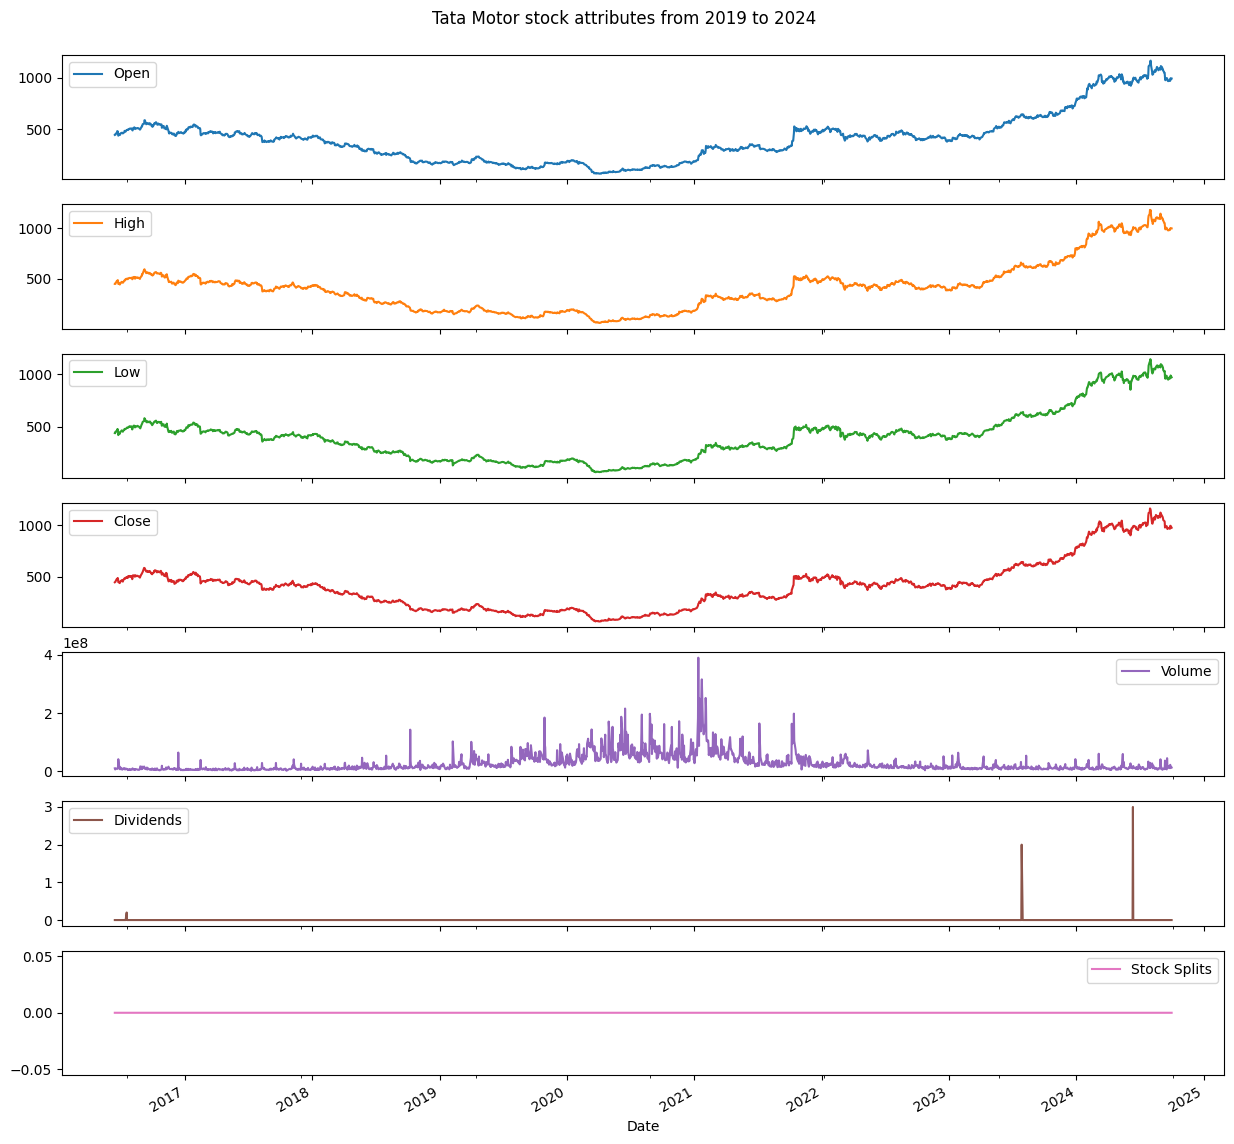

In [33]:
df.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Tata Motor stock attributes from 2019 to 2024', y=0.91)
plt.show()

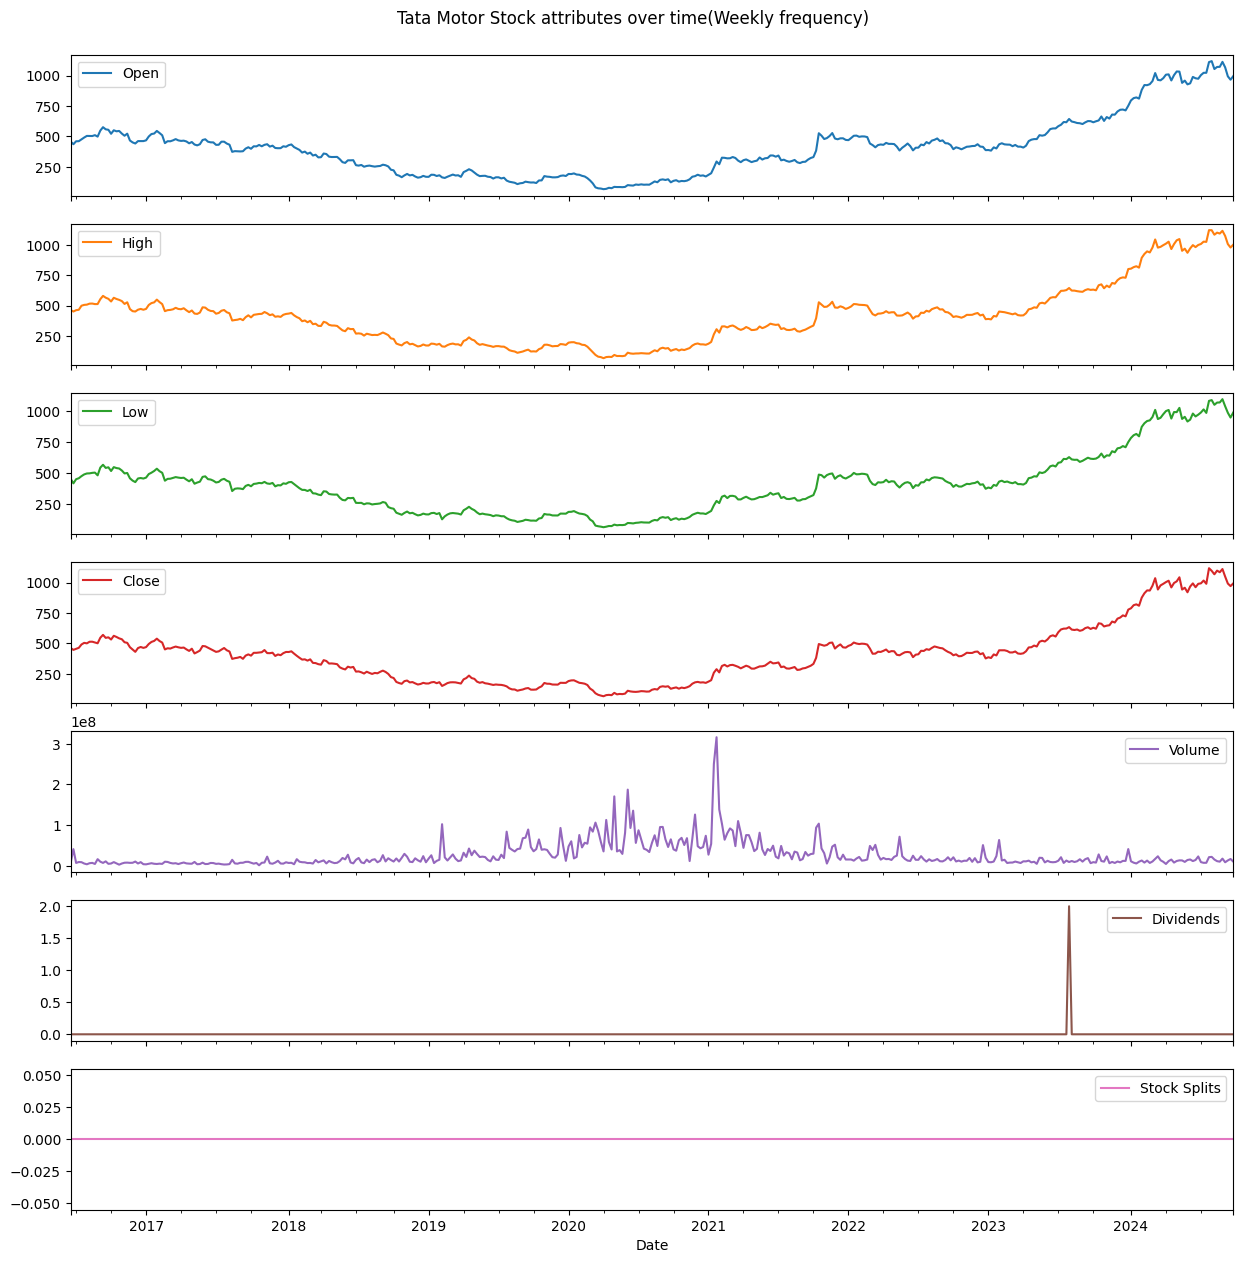

In [34]:
df.asfreq('W', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Tata Motor Stock attributes over time(Weekly frequency)', y=0.91)
plt.show()

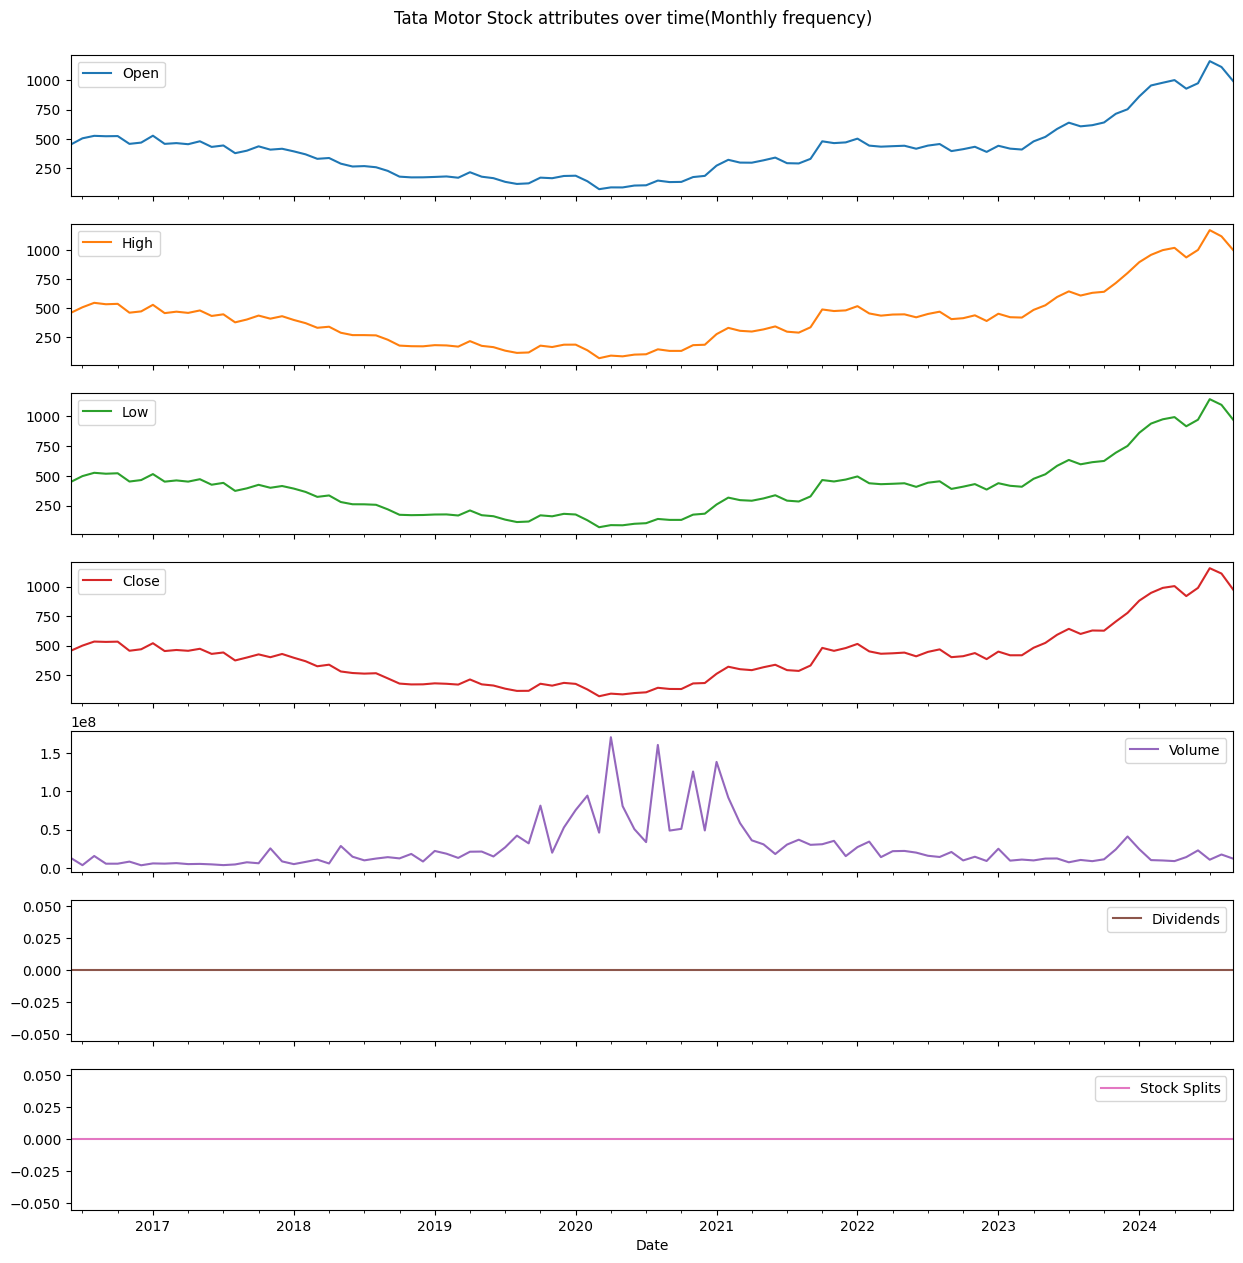

In [35]:
df.asfreq('ME', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Tata Motor Stock attributes over time(Monthly frequency)', y=0.91)
plt.show()

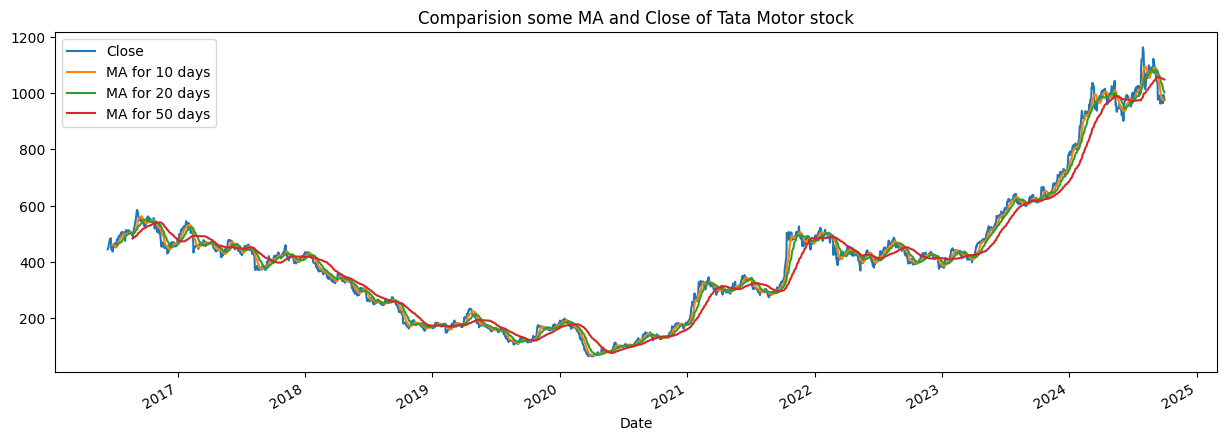

In [36]:
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    df[col_name] = df['Close'].rolling(ma).mean()

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some MA and Close of Tata Motor stock')
plt.show()

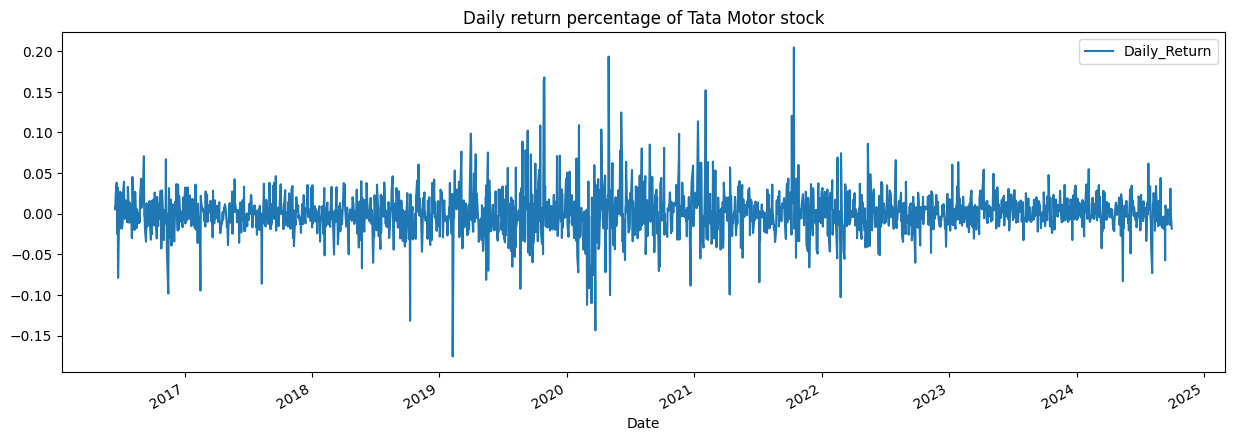

In [37]:
df['Daily_Return'] = df['Close'].pct_change()
# plot the daily return percentage
df.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Tata Motor stock')
plt.show()

In [38]:
closed_price = df['Close']
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_price)[...,None]).squeeze()
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA for 10 days,MA for 20 days,MA for 50 days,Daily_Return
Date,,,,,,,,,,,
2016-06-14 00:00:00+05:30,443.961097,450.865405,438.248910,445.451233,9615226,0.0,0.0,NaN,NaN,NaN,NaN
2016-06-15 00:00:00+05:30,446.941348,450.020967,444.308781,449.126892,5704865,0.0,0.0,NaN,NaN,NaN,0.008252
2016-06-16 00:00:00+05:30,446.742677,452.504522,443.116656,451.362091,7255454,0.0,0.0,NaN,NaN,NaN,0.004977
2016-06-17 00:00:00+05:30,457.968343,462.687106,454.292663,461.345978,7836702,0.0,0.0,NaN,NaN,NaN,0.022119
2016-06-20 00:00:00+05:30,461.693694,481.015799,457.223287,478.879913,9261350,0.0,0.0,NaN,NaN,NaN,0.038006
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24 00:00:00+05:30,974.000000,985.000000,972.599976,977.299988,12755422,0.0,0.0,976.689996,1026.282498,1050.998998,0.005660
2024-09-25 00:00:00+05:30,982.400024,982.500000,959.250000,963.599976,12959075,0.0,0.0,975.419995,1020.734995,1049.781998,-0.014018
2024-09-26 00:00:00+05:30,970.799988,994.950012,965.599976,993.150024,21640021,0.0,0.0,976.119995,1014.309995,1049.221998,0.030666


In [39]:
seq_len =15

In [40]:
X =[]
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i:i+seq_len])
    y.append(scaled_price[i+seq_len])
    
    
X = np.array(X)[...,None]
y = np.array(y)[...,None]
    
train_x = torch.from_numpy(X[:int(0.8*X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8*X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8*X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8*X.shape[0]):]).float()

print(train_x.shape , test_x.shape)
    

torch.Size([1627, 15, 1]) torch.Size([407, 15, 1])


10 epoch loss 0.014775963
20 epoch loss 0.012777853
30 epoch loss 0.011691011
40 epoch loss 0.009280559
50 epoch loss 0.004115878
60 epoch loss 0.0017123583
70 epoch loss 0.00071336614
80 epoch loss 0.0005342003
90 epoch loss 0.00046733735


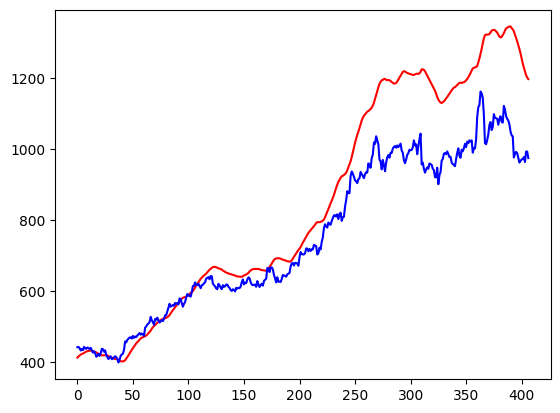

In [41]:
class Model(nn.Module):
    def __init__(self , input_size,hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
        
        
    def forward(self, x):
        output , (hidden,cell) = self.lstm(x)
        return self.fc(hidden[-1,:])
    
    
    
model = Model(1,96)

optimizer = torch.optim.Adam(model.parameters(), lr =0.001)

loss_fn = nn.MSELoss()

num_epochs =100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 ==0 and epoch !=0:
        print(epoch , "epoch loss" , loss.detach().numpy())
        
        
        
model.eval()
with torch.no_grad():
    output = model(test_x)
    
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())


plt.plot(pred.squeeze() , color ='red' , label = "Predicted")
plt.plot(real.squeeze() , color ='blue' , label = "Actual")
plt.show()